In [55]:
import argparse
import os
import math
import numpy as np
import random
import struct
import matplotlib.pyplot as plt

In [56]:
class GillespieSelectionSimulation:
    def __init__(self, L, N, s, migration_matrix, tfinal, seed=None, l0=0):
        self.L = L  # Total number of demes
        self.N = N  # Number of individuals in each deme
        self.s = s  # Selection coefficient
        self.migration_matrix = migration_matrix
        self.m = 0 #migration_matrix[0, 1]
        self.tfinal = tfinal
        self.l0 = l0  # Initial location for the mutant
        np.random.seed(seed)  # Setting the random seed
        print('Initialization complete. Seed:', seed)

    def simulate(self):
        t = 0.0
        mutants = np.zeros(self.L, dtype = np.uint32)
        mutants[self.l0] = 1 #Starting mutation at location l0
        start_state = mutants.copy()
        events = []
        mut_traj = [[t, mutants.copy()]]  # Initialize with the starting state

        print("Starting simulation...")
        while t < self.tfinal:

            if np.sum(mutants) == 0:
                print(f"All mutants extinct at time {t}. Reintroducing...")
                mutants = np.zeros(self.L, dtype = np.uint32)
                mutants[self.l0] = 1
                t = 0.0
                events = []
                mut_traj = [[t, mutants.copy()]] 
                continue
            
                        
            f = mutants / self.N
            rate_mutant_replaces_wt = self.N * f * (1 - f) * (1 + self.s)
            rate_wt_replaces_mutant = self.N * f * (1 - f)
            rate_migration_mutant_to_i_from_j = np.zeros((self.L, self.L))
            rate_migration_wt_to_i_from_j = np.zeros((self.L, self.L))

            for i in range(self.L):
                for j in range(self.L):
                    if i != j:
                        # Calculate migration rates of mutants and wild types from j to i
                        rate_migration_mutant_to_i_from_j[i][j] = self.N * f[j] * (1 - f[i]) * (1 + self.s) * self.migration_matrix[i][j]
                        rate_migration_wt_to_i_from_j[i][j] = self.N * f[i] * (1 - f[j]) * self.migration_matrix[i][j]

            total_rate = np.sum(rate_mutant_replaces_wt + rate_wt_replaces_mutant) + np.sum(rate_migration_mutant_to_i_from_j) + np.sum(rate_migration_wt_to_i_from_j)

            if total_rate == 0:
                print("No possible reactions. Skipping...")
                break

            tau = np.random.exponential(scale = 1 / total_rate)
            t += tau

            combined_rates = np.concatenate((rate_mutant_replaces_wt, rate_wt_replaces_mutant, 
                                             rate_migration_mutant_to_i_from_j.flatten(), rate_migration_wt_to_i_from_j.flatten()))
            reaction_probabilities = combined_rates / total_rate
            cumulative_prob = np.cumsum(reaction_probabilities)
            r = np.random.rand()
            reaction_index = np.where(cumulative_prob > r)[0][0]

            if reaction_index < self.L:
                event_type = 0
                updated_deme = reaction_index
                parent_deme = reaction_index
                mutants[updated_deme] += 1
            elif reaction_index < 2 * self.L:
                event_type = 1
                updated_deme = reaction_index - self.L
                parent_deme = updated_deme
                mutants[updated_deme] -= 1
            elif reaction_index < 2 * self.L + self.L**2:
                event_type = 2
                index = reaction_index - 2 * self.L
                i, j = index // self.L, index % self.L
                updated_deme = i
                parent_deme = j
                mutants[i] += 1
            else:
                event_type = 3
                index = reaction_index - (2 * self.L + self.L**2)
                i, j = index // self.L, index % self.L
                updated_deme = i
                parent_deme = j
                mutants[i] -= 1

            mut_traj.append([t, mutants.copy()])
            events.append([t, event_type, updated_deme, parent_deme])
            # print(f"Event at time {t}: {event_type} in deme {updated_deme}, from deme {parent_deme}")
        end_state = mutants.copy()
        demes = len(mutants)
        return events, mut_traj, start_state, end_state
    def save_events(self, events, start_state, end_state, filename):
        with open(filename, 'wb') as f:
            #Using struct.pack is not very efficient, but it seems to work fine for our sizes and I don't really care. It will cause problems for large deme sizes
            # Write the number of events as size_t. Can be L (8 bytes) or I (4 bytes)
            f.write(struct.pack('L', len(events))) # 'L' is long unsigned integer
            f.write(struct.pack('i', self.L))
            f.write(struct.pack('i', self.N)) # 'i' is int
            f.write(struct.pack('d', self.m)) # 'd' is double
            for i in start_state:
                f.write(struct.pack('i', i))
            for i in end_state:
                f.write(struct.pack('i', i))
            for i in events:
                f.write(struct.pack('d', i[0]))
                f.write(struct.pack('i', i[1]))
                f.write(struct.pack('i', i[2]))
                f.write(struct.pack('i', i[3]))
    def load_events(self, filename):
        with open(filename, 'rb') as f:
            output = []
            num_events = struct.unpack('L', f.read(8))
            demes = struct.unpack('i', f.read(4))
            pop_size = struct.unpack('i', f.read(4))
            m = struct.unpack('d', f.read(8))
            output.append(num_events)  # Read and unpack one integers
            output.append(demes)
            output.append(pop_size)
            output.append(m)
            for i in range(demes[0]):
                output.append(struct.unpack('i', f.read(4)))
                output.append(struct.unpack('i', f.read(4)))
            for i in range(num_events[0]):
                output.append(struct.unpack('d', f.read(8)))
                output.append(struct.unpack('i', f.read(4)))
                output.append(struct.unpack('i', f.read(4)))
                output.append(struct.unpack('i', f.read(4)))
            return output

In [57]:
def plot_mutant_trajectories(mut_traj, L):
    times = [state[0] for state in mut_traj]
    mutant_counts = [state[1] for state in mut_traj]
    plt.figure(figsize=(10, 6))
    for deme in range(L):
        plt.plot(times, [m[deme] for m in mutant_counts], label=f'Deme {deme+1}')
    plt.xlabel('Time')
    plt.ylabel('Number of Mutants')
    plt.title('Mutant Trajectories Over Time')
    #plt.legend()
    plt.show()


In [58]:

class MigrationMatrixGenerator:
    def __init__(self, deme_dimension, migration_rate):
        self.deme_dimension = deme_dimension
        self.migration_rate = migration_rate
    

    def generate_1Dmatrix(self):
        M = np.zeros((self.deme_dimension, self.deme_dimension))

        for i in range(self.deme_dimension):
            if i > 0:
                M[i, i - 1] = self.migration_rate
            if i < self.deme_dimension - 1:
                M[i, i + 1] = self.migration_rate

        return M
    
    
    def generate_2Dmatrix(self):
        """
        Generates a 2D migration matrix for a square grid of demes.
        Each deme can migrate to its immediate neighbors (up, down, left, right).
        Diagonal elements are set to 0, indicating no self-migration.
        """
        z = math.sqrt(self.deme_dimension)
        if not z.is_integer():
            raise ValueError("Deme dimension must be a perfect square for a 2D grid.")
        z = int(z)

        M = np.zeros((self.deme_dimension, self.deme_dimension))

        for i in range(self.deme_dimension):
            for j in range(self.deme_dimension):
                # Check for right neighbor
                if j == i + 1 and (i + 1) % z != 0:
                    M[i, j] = self.migration_rate
                # Check for down neighbor
                elif j == i + z and j < self.deme_dimension:
                    M[i, j] = self.migration_rate

                # Ensure migration is bidirectional
                M[j, i] = M[i, j]

        return M

    def generate_3Dmatrix(self):
        """
        Generates a 3D migration matrix for a cubic grid of demes.
        Each deme can migrate to its immediate neighbors along the x, y, and z axes.
        Diagonal elements are set to 0, indicating no self-migration.
        """
        cube_root = round(self.deme_dimension ** (1/3))
        if cube_root ** 3 != self.deme_dimension:
            raise ValueError("Deme dimension must be a cube number for a 3D grid.")

        M = np.zeros((self.deme_dimension, self.deme_dimension))

        for i in range(self.deme_dimension):
            x, y, z = np.unravel_index(i, (cube_root, cube_root, cube_root))

            # Check neighbors in each direction (left, right, up, down, front, back)
            for dx, dy, dz in [(-1, 0, 0), (1, 0, 0), (0, -1, 0), (0, 1, 0), (0, 0, -1), (0, 0, 1)]:
                nx, ny, nz = x + dx, y + dy, z + dz
                if 0 <= nx < cube_root and 0 <= ny < cube_root and 0 <= nz < cube_root:
                    neighbor_index = np.ravel_multi_index((nx, ny, nz), (cube_root, cube_root, cube_root))
                    M[i, neighbor_index] = self.migration_rate

        return M

    def generate_island_model_matrix(self):
        """
        Generates a migration matrix based on the island model.
        Each deme has an equal migration rate to every other deme.
        Diagonal elements are set to 0, indicating no self-migration.
        """
        M = np.full((self.deme_dimension, self.deme_dimension), self.migration_rate)
        np.fill_diagonal(M, 0)  # Set diagonal elements to 0
        return M    

Initialization complete. Seed: None
Starting simulation...
All mutants extinct at time 2.031316742220521. Reintroducing...
All mutants extinct at time 0.30423736491319525. Reintroducing...
All mutants extinct at time 4.546194418636674. Reintroducing...
All mutants extinct at time 1.0058709788119797. Reintroducing...
All mutants extinct at time 3.3008272740977342. Reintroducing...
All mutants extinct at time 0.340385571031172. Reintroducing...
All mutants extinct at time 0.5722207850079434. Reintroducing...
All mutants extinct at time 0.5702233964094878. Reintroducing...
All mutants extinct at time 1.2200114158169226. Reintroducing...
All mutants extinct at time 0.6401446716034362. Reintroducing...
All mutants extinct at time 0.09571474596007024. Reintroducing...
All mutants extinct at time 0.04274987600428453. Reintroducing...
All mutants extinct at time 14.99946875535283. Reintroducing...
All mutants extinct at time 0.6161976589384585. Reintroducing...
All mutants extinct at time 10.3

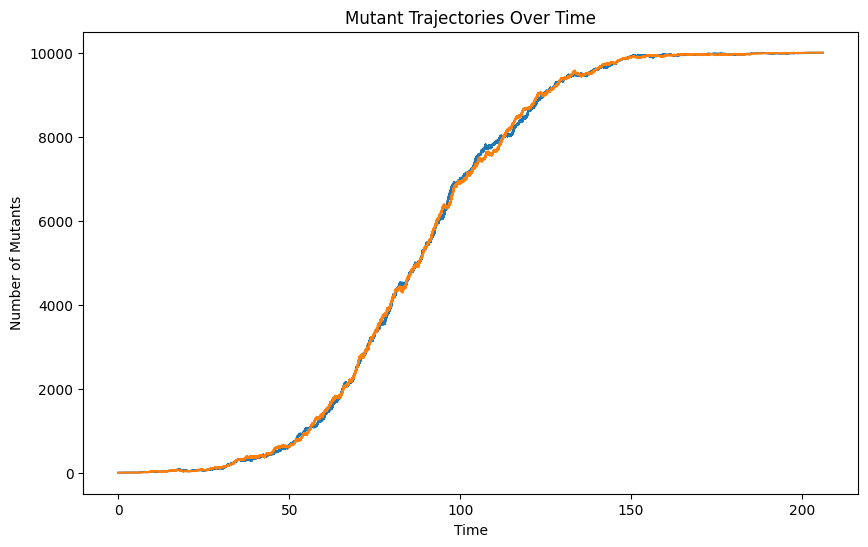

[(790713,), (2,), (10000,), (0.25,), (1,), (0,), (10000,), (10000,), (1.5035759988933013,), (0,), (0,), (0,), (1.9403180836373297,), (3,), (0,), (1,), (2.723742229550458,), (0,), (0,), (0,), (3.2014505708182206,), (0,), (0,), (0,), (3.2677322723127418,), (0,), (0,), (0,), (3.271376747746636,), (1,), (0,), (0,), (3.3037669168978505,), (0,), (0,), (0,), (3.3198013280686056,), (0,), (0,), (0,), (3.3451162803895227,), (0,), (0,), (0,), (3.3726050032206585,), (1,), (0,), (0,), (3.426500424219998,), (1,), (0,), (0,), (3.589830139233644,), (0,), (0,), (0,), (3.663820188182465,), (0,), (0,), (0,), (3.6668216817106165,), (0,), (0,), (0,), (3.681918721761796,), (1,), (0,), (0,), (3.7750007480238046,), (0,), (0,), (0,), (3.8220459708088677,), (0,), (0,), (0,), (3.8386348274079327,), (0,), (0,), (0,), (3.902902661442993,), (3,), (0,), (1,), (3.910770308444753,), (3,), (0,), (1,), (3.9481435455706544,), (1,), (0,), (0,), (3.948436001934433,), (0,), (0,), (0,), (4.0301279454279575,), (1,), (0,), (0,

In [59]:
# Example usage
L = 1
N = 10000
s = 0.05
m = 0
migration_matrix = MigrationMatrixGenerator(L, m).generate_1Dmatrix()

# migration_matrix = np.zeros((L, L))  # Example migration matrix

tfinal = 5000
simulation = GillespieSelectionSimulation(L, N, s, migration_matrix, tfinal)
events, mut_traj, start_state, end_state = simulation.simulate()
plot_mutant_trajectories(mut_traj, L)
simulation.save_events(events, start_state, end_state, 'events.bin')
loaded_events = simulation.load_events('events.bin')

print(loaded_events[0:100])  # Optional: Print to verify contents

# print(mut_traj)
#for event in events[0:10]:
#     print(event)  # Print each event



In [60]:
print(loaded_events[10000:10466])

[(20.046204427654267,), (3,), (1,), (0,), (20.046723622748885,), (2,), (1,), (0,), (20.058042683047226,), (1,), (1,), (1,), (20.058682520388945,), (1,), (1,), (1,), (20.05942286149967,), (1,), (0,), (0,), (20.059766718455144,), (3,), (0,), (1,), (20.06193951284639,), (1,), (1,), (1,), (20.06527790746142,), (0,), (1,), (1,), (20.07237900374009,), (1,), (0,), (0,), (20.072694319542254,), (1,), (0,), (0,), (20.07786552652505,), (0,), (1,), (1,), (20.081015384838206,), (1,), (1,), (1,), (20.08765412461092,), (1,), (0,), (0,), (20.08897157301525,), (3,), (0,), (1,), (20.09132339787251,), (0,), (0,), (0,), (20.09386525094919,), (2,), (0,), (1,), (20.102630913922916,), (1,), (0,), (0,), (20.105972656246156,), (0,), (0,), (0,), (20.109789888744892,), (2,), (0,), (1,), (20.112148043862206,), (0,), (0,), (0,), (20.113085389067546,), (0,), (1,), (1,), (20.120471602093197,), (3,), (0,), (1,), (20.124201168915818,), (0,), (1,), (1,), (20.124889914585165,), (0,), (1,), (1,), (20.126821456021542,), (